In [129]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score, make_scorer
import numpy as np
import pickle
from sklearn.impute import KNNImputer
import imblearn
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from utils.general_utils import save_model
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, RepeatedStratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score
import imblearn
from imblearn.pipeline import Pipeline

from sklearn.manifold import TSNE # TSNE module
from sklearn.decomposition import PCA



from utils.general_utils import get_outlier_info, get_outlier_val_counts, clean_outliers
from utils.saver_utils import save_normalizer, load_normalizer
from utils.saver_utils import save_dataset, load_dataset 
from scipy.stats import skew



In [2]:
og_df = pd.read_csv('dataset/TrainDataset2023.csv')
og_df.rename(columns={'pCR (outcome)': 'pcr', 'RelapseFreeSurvival (outcome)': 'rfs'}, inplace=True)

In [3]:
int_col_mask = og_df.drop(columns=['ID']).dtypes == 'int64'
categorical_features = list(og_df.drop(columns=['ID']).columns[int_col_mask])

# Ignoring 'original_shape_VoxelVolume' because even though it is a int column it is not a categorical feature

categorical_features.remove('original_shape_VoxelVolume')
categorical_features

['pcr',
 'ER',
 'PgR',
 'HER2',
 'TrippleNegative',
 'ChemoGrade',
 'Proliferation',
 'HistologyType',
 'LNStatus',
 'TumourStage']

In [4]:
int_col_index = [i for i, x in enumerate(np.array(int_col_mask)) if x]
int_col_index

[0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 25]

In [5]:
missing_vals = np.sum(og_df == 999)
missing_cols_valuecounts = missing_vals[missing_vals > 0]
missing_cols_valuecounts

pcr                5
PgR                1
HER2               1
TrippleNegative    1
ChemoGrade         3
Proliferation      2
HistologyType      3
LNStatus           1
dtype: int64

In [6]:
impute_knn = KNNImputer(n_neighbors=3, missing_values=999)
imputed_arr = impute_knn.fit_transform(og_df.drop(columns=['ID']))

## All the missing values are from the classification target column and other categorical features, So we round the KNN imputed values to the nearest neighbour

In [7]:
for idx in int_col_index:
    imputed_arr[:, idx] = np.rint(imputed_arr[:, idx])

In [8]:
imputed_df = pd.DataFrame.from_records(imputed_arr, columns=og_df.columns[1:])

In [9]:
skew_processing_cols = imputed_df.drop(columns = set(categorical_features).union({'pcr', 'rfs'})).columns

# Handling the skew depends on weather it is positively or negatively skewed

In [10]:
from scipy.stats import boxcox


In [11]:
skew_handling_df = imputed_df.copy()

right_skew_counter = 0
left_skew_counter = 0
other_counter = 0

for col_name in skew_processing_cols:
    data_skewness = skew(skew_handling_df[col_name])
    if data_skewness > 0:
        skew_handling_df[col_name] = np.log1p(skew_handling_df[col_name])
        right_skew_counter += 1
        
    elif data_skewness < 0:
        skew_handling_df[col_name] = boxcox(skew_handling_df[col_name] + 1)[0]
        left_skew_counter += 1
    else:
        other_counter += 1


C:\Users\sudar\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


1. Right skewed value 79
2. Left skewed value 28
3. Other  value 0

In [12]:
print(f'Right skewed value {right_skew_counter}')
print(f'Left skewed value {left_skew_counter}')
print(f'Other  value {other_counter}')

Right skewed value 80
Left skewed value 28
Other  value 0


In [13]:
multiclass_categorical_features = []
others = []

for cat_col_name in categorical_features:
    temp_len = len(skew_handling_df[cat_col_name].value_counts())
    if temp_len > 2:
        multiclass_categorical_features.append(cat_col_name)
    else:
        others.append(temp_len)

multiclass_categorical_features, others

(['ChemoGrade', 'Proliferation', 'TumourStage'], [2, 2, 2, 2, 2, 2, 2])

In [14]:
skew_handling_df = pd.get_dummies(skew_handling_df, columns=multiclass_categorical_features)

# Converting bool one hot encoding to integer one hot encoding

In [15]:
multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']

In [16]:
for column in multi_category_variables:
    skew_handling_df[column] = skew_handling_df[column].astype(np.float32)

# Checking for NaN values and handling it by simple removing it

In [17]:
nan_cols = skew_handling_df.columns[skew_handling_df.isnull().sum() > 0]
skew_handling_df.drop(columns=nan_cols, inplace=True)

In [18]:
categorical_features_labels = categorical_features + multi_category_variables
temp_categorical_features_labels = categorical_features_labels

for col_name in multiclass_categorical_features:
    temp_categorical_features_labels.remove(col_name)

temp_categorical_features_labels.remove('pcr')

continous_features_labels = skew_handling_df.drop(columns=temp_categorical_features_labels+['pcr', 'rfs']).columns

In [46]:
# val_dict_list = []

# for col in skew_handling_df.drop(columns=['pcr', 'rfs'] + temp_categorical_features_labels).columns:
    
#     lower_outlier_gate, upper_outlier_gate = get_outlier_info(train[col])
#     skew_handling_df = clean_outliers(skew_handling_df, col, lower_outlier_gate, upper_outlier_gate)
    
#     val_dict = get_outlier_val_counts(skew_handling_df[col], col, lower_outlier_gate, upper_outlier_gate)
#     val_dict_list.append(val_dict)
    
    

            
# print(val_dict_list)

In [ ]:
train, test = train_test_split(skew_handling_df, test_size=0.20)

In [ ]:
train_continous_feature_array = train[continous_features_labels].to_numpy()

test_continous_feature_array = test[continous_features_labels].to_numpy()

In [21]:
train, test = train_test_split(skew_handling_df, test_size=0.20)


train_continous_feature_array = train[continous_features_labels].to_numpy()

test_continous_feature_array = test[continous_features_labels].to_numpy()
# scalerTrainX = StandardScaler()
# scalerTrainY = StandardScaler()
# scalerTrainX = RobustScaler()
# scalerTrainY = RobustScaler()

scalerTrainX = MinMaxScaler()
scalerTrainY = MinMaxScaler()


train_cont_X = scalerTrainX.fit_transform(train_continous_feature_array)
train_cat_X = train[categorical_features_labels].to_numpy()
trainX = np.hstack((train_cat_X, train_cont_X))
                   
trainY = scalerTrainY.fit_transform(train['rfs'].to_numpy().reshape(-1, 1))

                   
test_cont_X = scalerTrainX.transform(test_continous_feature_array)
test_cat_X = test[categorical_features_labels].to_numpy()
testX = np.hstack((test_cat_X, test_cont_X))
                   
testY = scalerTrainY.transform(test['rfs'].to_numpy().reshape(-1, 1))

In [22]:
regressor = RandomForestRegressor()
regressor.fit(trainX, trainY.ravel())

RandomForestRegressor()

In [23]:

predicted = regressor.predict(testX)
test_mse_error = mean_squared_error(testY, predicted,)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')



MSE error: 0.03527661772200196
MAE error: 0.14100951086881341
R2 error: 0.0592750489593189


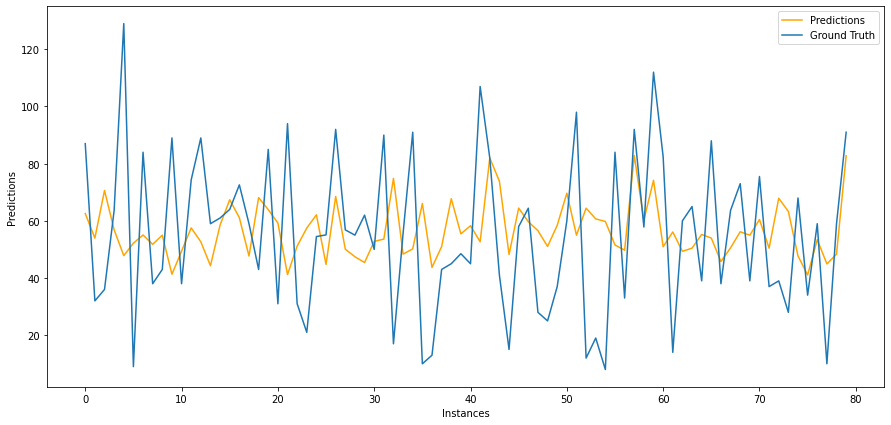

In [37]:

plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), scalerTrainY.inverse_transform(predicted.reshape(1,-1)).flatten(),
         color='orange', label='Predictions')
plt.plot(list(range(len(predicted))),scalerTrainY.inverse_transform(testY.reshape(1,-1)).flatten(),
         label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

# RF Feature Importance Plot

In [37]:
feature_names = train.drop(columns=['pcr', 'rfs']).columns

In [29]:
feature_importances = pd.Series(regressor.feature_importances_, index=feature_names)
relevant_features = feature_importances.sort_values(ascending=False).index

<Axes: >

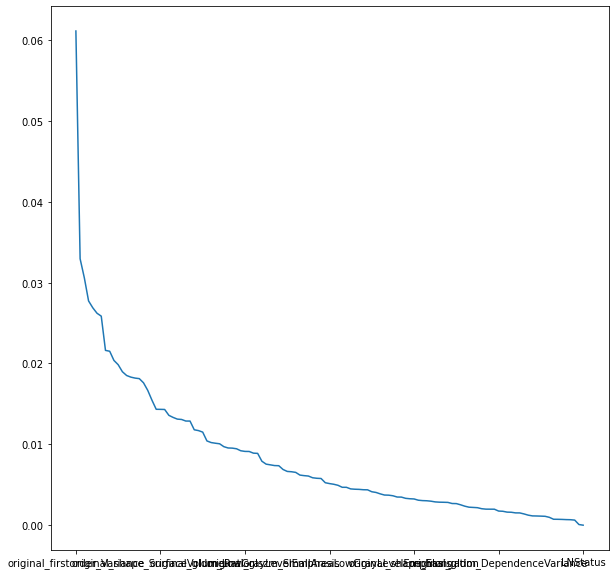

In [43]:
feature_importances.sort_values(ascending=False).plot(kind='line', figsize=(10,10))

In [96]:
RF_imp_cols = feature_importances[feature_importances > 0.01].index

# Training with RF Feature important columns

In [97]:
feature_imp_df = skew_handling_df[list(RF_imp_cols) + ['rfs', 'pcr']].copy()

In [98]:
train, test = train_test_split(feature_imp_df, test_size=0.20)

RF_Imp_continous_features_labels = list(set(RF_imp_cols).intersection(set(continous_features_labels)))
RF_Imp_categorical_features_labels = list(set(RF_imp_cols).intersection(set(categorical_features_labels)))

# Handling Outliers

In [83]:
# val_dict_list = []

# for col in train.drop(columns=['pcr', 'rfs'] + RF_Imp_categorical_features_labels).columns:
    
#     lower_outlier_gate, upper_outlier_gate = get_outlier_info(train[col])
#     train = clean_outliers(train, col, lower_outlier_gate, upper_outlier_gate)
    
#     #Sanity Check
#     val_dict = get_outlier_val_counts(train[col], col, lower_outlier_gate, upper_outlier_gate)
#     val_dict_list.append(val_dict)
    
    

            
# print(val_dict_list)

[{'col_name': 'original_shape_MinorAxisLength', 2.2003805538722627: [0, Series([], Name: original_shape_MinorAxisLength, dtype: float64)], 4.541244488746283: [0, Series([], Name: original_shape_MinorAxisLength, dtype: float64)], 'total_outliers': 0}, {'col_name': 'original_shape_Sphericity', -0.19379253438028698: [0, Series([], Name: original_shape_Sphericity, dtype: float64)], 2.0956997521560883: [0, Series([], Name: original_shape_Sphericity, dtype: float64)], 'total_outliers': 0}, {'col_name': 'original_shape_SurfaceArea', 5.790815176058681: [0, Series([], Name: original_shape_SurfaceArea, dtype: float64)], 10.829732688882045: [0, Series([], Name: original_shape_SurfaceArea, dtype: float64)], 'total_outliers': 0}, {'col_name': 'original_shape_SurfaceVolumeRatio', 0.10608146646960118: [0, Series([], Name: original_shape_SurfaceVolumeRatio, dtype: float64)], 0.5393058134861995: [0, Series([], Name: original_shape_SurfaceVolumeRatio, dtype: float64)], 'total_outliers': 0}, {'col_name':

In [99]:
train_continous_feature_array = train[RF_Imp_continous_features_labels].to_numpy()

test_continous_feature_array = test[RF_Imp_continous_features_labels].to_numpy()

# scalerTrainX = StandardScaler()
# scalerTrainY = StandardScaler()
# scalerTrainX = RobustScaler()
# scalerTrainY = RobustScaler()

scalerTrainX = MinMaxScaler()
scalerTrainY = MinMaxScaler()


train_cont_X = scalerTrainX.fit_transform(train_continous_feature_array)
train_cat_X = train[RF_Imp_categorical_features_labels].to_numpy()
trainX = np.hstack((train_cat_X, train_cont_X))
                   
trainY = scalerTrainY.fit_transform(train['rfs'].to_numpy().reshape(-1, 1))

                   
test_cont_X = scalerTrainX.transform(test_continous_feature_array)
test_cat_X = test[RF_Imp_categorical_features_labels].to_numpy()
testX = np.hstack((test_cat_X, test_cont_X))
                   
testY = scalerTrainY.transform(test['rfs'].to_numpy().reshape(-1, 1))

In [91]:
# pca = PCA(n_components=3)
# pca_trainX = pca.fit_transform(trainX)
# pca_testX = pca.transform(testX)

In [92]:
pca_trainX.shape, pca_testX.shape

((320, 3), (80, 3))

In [100]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((320, 35), (320, 1), (80, 35), (80, 1))

Train MSE error: 0.01757390496378402
Train MAE error: 0.0991212112402707
Train R2 error: 0.5403507061411653

Test MSE error: 0.03061861034551062
Test MAE error: 0.1440262676931341
Test R2 error: -0.2658951534774452


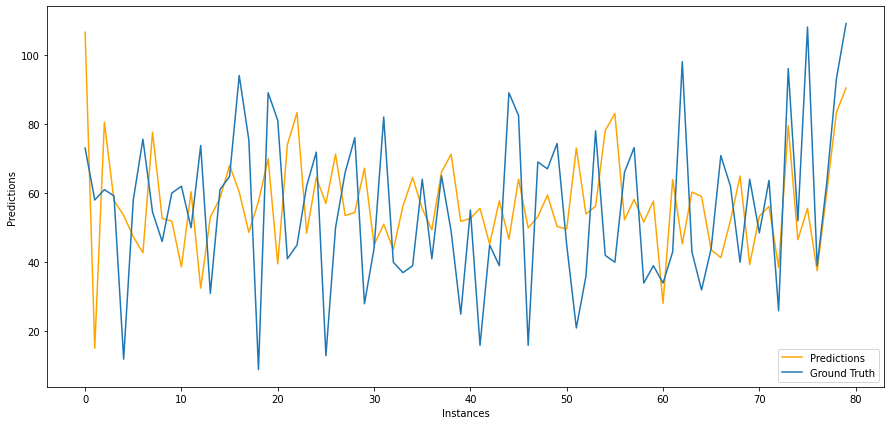

In [124]:
regrMLP  = MLPRegressor(random_state=1, batch_size=8, hidden_layer_sizes=(100,))
regrMLP.fit(trainX, trainY.ravel())

predicted = regrMLP.predict(trainX)
train_mse_error = mean_squared_error(trainY.ravel(), predicted)
train_mae_error = mean_absolute_error(trainY.ravel(), predicted)
train_r2_error = r2_score(trainY.ravel(), predicted)

print(f'Train MSE error: {train_mse_error}')
print(f'Train MAE error: {train_mae_error}')
print(f'Train R2 error: {train_r2_error}')

print()

predicted = regrMLP.predict(testX)
test_mse_error = mean_squared_error(testY, predicted,)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)

print(f'Test MSE error: {test_mse_error}')
print(f'Test MAE error: {test_mae_error}')
print(f'Test R2 error: {test_r2_error}')


plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), scalerTrainY.inverse_transform(predicted.reshape(1,-1)).flatten(),
         color='orange', label='Predictions')
plt.plot(list(range(len(predicted))),scalerTrainY.inverse_transform(testY.reshape(1,-1)).flatten(),
         label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()


Train MSE error: 0.005065483315501316
Train MAE error: 0.05431969762737845
Train R2 error: 0.867511185827959

Test MSE error: 0.025340929607569042
Test MAE error: 0.12908241705111112
Test R2 error: -0.047694836991132306


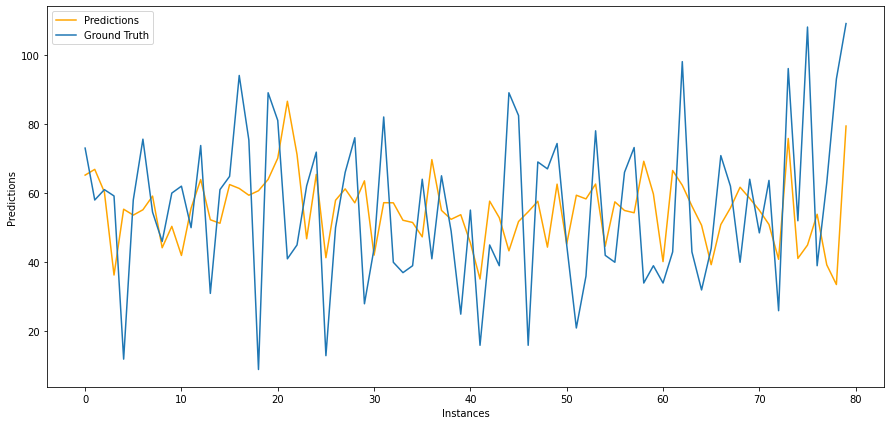

In [118]:
regressor = RandomForestRegressor(n_estimators=50, max_depth=20)
regressor.fit(trainX, trainY.ravel())

predicted = regressor.predict(trainX)
train_mse_error = mean_squared_error(trainY.ravel(), predicted)
train_mae_error = mean_absolute_error(trainY.ravel(), predicted)
train_r2_error = r2_score(trainY.ravel(), predicted)

print(f'Train MSE error: {train_mse_error}')
print(f'Train MAE error: {train_mae_error}')
print(f'Train R2 error: {train_r2_error}')

print()

predicted = regressor.predict(testX)
test_mse_error = mean_squared_error(testY, predicted,)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)

print(f'Test MSE error: {test_mse_error}')
print(f'Test MAE error: {test_mae_error}')
print(f'Test R2 error: {test_r2_error}')


plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), scalerTrainY.inverse_transform(predicted.reshape(1,-1)).flatten(),
         color='orange', label='Predictions')
plt.plot(list(range(len(predicted))),scalerTrainY.inverse_transform(testY.reshape(1,-1)).flatten(),
         label='Ground Truth')
plt.xlabel("Instances")`
plt.ylabel("Predictions")
plt.legend()
plt.show()

In [1]:
plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), scalerTrainY.inverse_transform(predicted.reshape(1,-1)).flatten(),
         color='orange', label='Predictions')
plt.plot(list(range(len(predicted))),scalerTrainY.inverse_transform(trainY.ravel().reshape(1,-1)).flatten(),
         label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

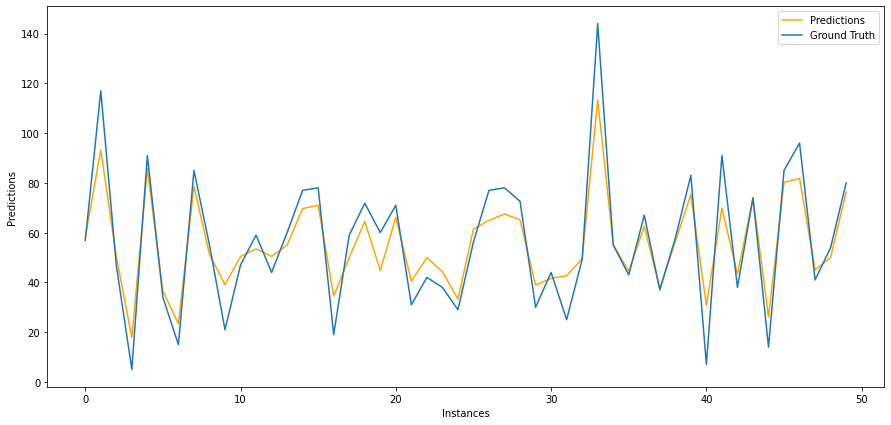

In [122]:

slicing_index = 50

plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted[:slicing_index]))), scalerTrainY.inverse_transform(predicted[:slicing_index].reshape(1,-1)).flatten(),
         color='orange', label='Predictions')
plt.plot(list(range(len(predicted[:slicing_index]))),scalerTrainY.inverse_transform(trainY[:slicing_index].ravel().reshape(1,-1)).flatten(),
         label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

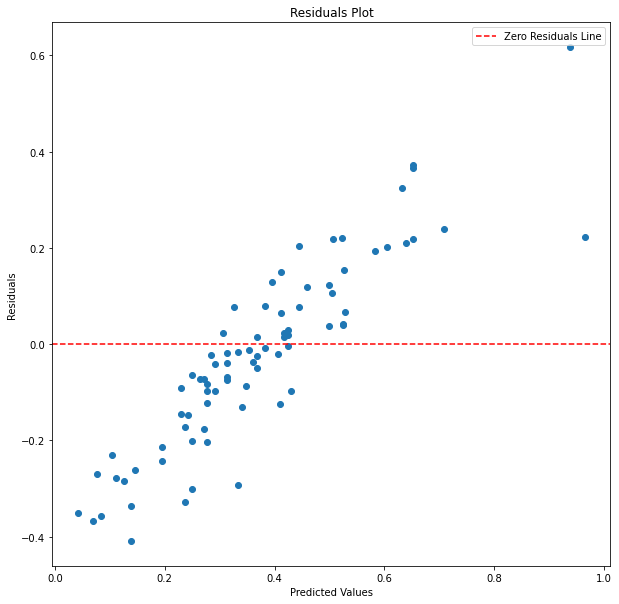

In [94]:
# Calculate residuals
residuals = testY.ravel() - predicted

# Plot residuals
plt.figure(figsize=(10,10))
plt.scatter(testY.ravel(), residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Residuals Line")
plt.legend()
plt.show()

# Performing Hyperparameter Grid search to improve the overfit RF model

In [145]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features' : [10, 20, 35]
}

In [149]:
# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

# Create a scoring function for GridSearchCV
# scoring = {'R2': make_scorer(r2_score), 'MAE': make_scorer(mean_absolute_error)}
scoring = {'R2': make_scorer(r2_score)}

# Create a KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring=scoring, cv=kf, refit='R2', return_train_score=True)

# Fit the model to the data
grid_search.fit(trainX, trainY.ravel())

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
test_predictions = best_model.predict(testX)
test_r2 = r2_score(testY, test_predictions)
test_mae = mean_absolute_error(testY, test_predictions)

print("Test R2:", test_r2)
print("Test MAE:", test_mae)

Best Hyperparameters: {'max_depth': 10, 'max_features': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Test R2: -0.025991741905119436
Test MAE: 0.12867295115452718


In [147]:
testX.shape, testY.shape

((80, 35), (80, 1))

In [148]:

predicted = best_model.predict(trainX)
train_mse_error = mean_squared_error(trainY.ravel(), predicted)
train_mae_error = mean_absolute_error(trainY.ravel(), predicted)
train_r2_error = r2_score(trainY.ravel(), predicted)

print(f'Train MSE error: {train_mse_error}')
print(f'Train MAE error: {train_mae_error}')
print(f'Train R2 error: {train_r2_error}')

print()

predicted = regressor.predict(testX)
test_mse_error = mean_squared_error(testY, predicted,)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)

print(f'Test MSE error: {test_mse_error}')
print(f'Test MAE error: {test_mae_error}')
print(f'Test R2 error: {test_r2_error}')


Train MSE error: 0.013051061633116113
Train MAE error: 0.08679455373742775
Train R2 error: 0.6586466538807171

Test MSE error: 0.025340929607569042
Test MAE error: 0.12908241705111112
Test R2 error: -0.047694836991132306


# Logistic Regression

In [140]:
from sklearn.linear_model import LinearRegression


In [142]:
clf = LinearRegression()
clf.fit(trainX, trainY.ravel())

LinearRegression()

In [143]:

predicted = clf.predict(trainX)
train_mse_error = mean_squared_error(trainY.ravel(), predicted)
train_mae_error = mean_absolute_error(trainY.ravel(), predicted)
train_r2_error = r2_score(trainY.ravel(), predicted)

print(f'Train MSE error: {train_mse_error}')
print(f'Train MAE error: {train_mae_error}')
print(f'Train R2 error: {train_r2_error}')

print()

predicted = regressor.predict(testX)
test_mse_error = mean_squared_error(testY, predicted,)
test_mae_error = mean_absolute_error(testY, predicted)
test_r2_error = r2_score(testY, predicted)

print(f'Test MSE error: {test_mse_error}')
print(f'Test MAE error: {test_mae_error}')
print(f'Test R2 error: {test_r2_error}')


Train MSE error: 0.030740131511441404
Train MAE error: 0.13815221906543423
Train R2 error: 0.19598519671752312

Test MSE error: 0.025340929607569042
Test MAE error: 0.12908241705111112
Test R2 error: -0.047694836991132306
